In [1691]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import matplotlib.dates as mdates # type: ignore
import matplotlib.ticker as ticker # type: ignore
from matplotlib.axis import Axis # type: ignore
import datetime as dt 

import time
start = time.time()

In [1692]:
def get_data2(filename):    
    data = pd.read_csv(filename) #, names=["Interval","kWh"])
    return data
    
def conso_byhour(day):
    ''' 
    display conso by hour for the chosen day
    '''
    conso_day=conso_data[conso_data['days']==day].copy()  # type: ignore # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))

    conso_hours = conso_day.copy()
    conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
    conso_hours#.info()
    # group by hour
    groupedbyhour = conso_hours[['hours','kWh']].groupby('hours', sort=False)
    groupedbyhour.count()
    len(groupedbyhour)
    x = np.arange(1,len(groupedbyhour)+1)

    #groupedbyhour.count().plot(grid=True,xticks=x)
    plt.figure(figsize=(12, 8),facecolor='darkcyan')
    values = groupedbyhour.count().kWh
    #ax = plt.bar(x,groupedbyhour.count().kWh)
    ax = values.plot(kind="bar",color='green',width=.8)
    ax.set_facecolor('antiquewhite')
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) - {day}')
    plt.xlim(-1,len(x)+1)
    plt.xticks(rotation=30);
    
    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in values]
    
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom",
            fontfamily='calibri', fontsize=16, fontweight='bold', color='blue'
        )
    
    
def from_csv(csv_file): 
    ''' save data to csv  '''
    df = pd.read_csv(csv_file)
    return df
    
def to_csv(csv_file, df):
    ''' read data from csv'''
    df.to_csv(csv_file, index=False)


### conso.csv créé par pi4 node-red onglet Linky
#### création de conso_data 

In [1693]:
conso_file = r"\\192.168.0.175\pihome\Documents\conso2.csv"
conso_data = get_data2(conso_file)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2374425 entries, 0 to 2374424
Data columns (total 2 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Interval  int64  
 1   kWh       float64
dtypes: float64(1), int64(1)
memory usage: 36.2 MB


# reduce to 1 million events

In [1694]:
conso_data = conso_data.tail(1000000)
conso_data.reset_index(drop=True, inplace=True)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   Interval  1000000 non-null  int64  
 1   kWh       1000000 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 15.3 MB


### conversion millisec -> sec

In [1695]:
conso_data['sec']=conso_data['Interval']/1000
conso_data

,Interval,kWh,sec
0,26784,0.13,26.784
1,26736,0.13,26.736
2,26795,0.13,26.795
3,26771,0.13,26.771
4,26778,0.13,26.778
...,...,...,...
999995,29060,0.12,29.060
999996,29133,0.12,29.133
999997,28961,0.12,28.961
999998,28813,0.12,28.813


### conversion Interval -> kWh

In [1696]:
conso_data['Wh']=3600000/conso_data['Interval']
conso_data


,Interval,kWh,sec,Wh
0,26784,0.13,26.784,134.408602
1,26736,0.13,26.736,134.649910
2,26795,0.13,26.795,134.353424
3,26771,0.13,26.771,134.473871
4,26778,0.13,26.778,134.438718
...,...,...,...,...
999995,29060,0.12,29.060,123.881624
999996,29133,0.12,29.133,123.571208
999997,28961,0.12,28.961,124.305100
999998,28813,0.12,28.813,124.943602


### Cumul Total interval

In [1697]:
conso_data['cumul(ms)']=conso_data['Interval'].cumsum(axis=0)

In [1698]:
l=len(conso_data)-1
cumtime= int(conso_data._get_value(l,'cumul(ms)')*1000)  # convert to microseconds
cumtime

27015672844000

### Calcul de la date de base = now - cumul_interval

In [1699]:
from datetime import datetime, timedelta
now = datetime.now()
# conso.csv dynamique
base = now - timedelta(microseconds=cumtime)
base  # date de début

datetime.datetime(2024, 8, 30, 4, 37, 41, 856794)

In [1700]:
conso_data['cumul(ms)'][conso_data['cumul(ms)'].isna()==True]

Series([], Name: cumul(ms), dtype: int64)

In [1701]:
conso_data.iloc[0]


Interval     26784.000000
kWh              0.130000
sec             26.784000
Wh             134.408602
cumul(ms)    26784.000000
Name: 0, dtype: float64

### Recréer les dates à partir des cumuls par impulsion


In [1702]:
base

datetime.datetime(2024, 8, 30, 4, 37, 41, 856794)

## créer les dates

In [1703]:
# create column 'dates' with time cumulated time from base
conso_data['dates'] = [base + dt.timedelta(microseconds=t*1000) for t in conso_data['cumul(ms)']]
conso_data['dates']

0        2024-08-30 04:38:08.640794
1        2024-08-30 04:38:35.376794
2        2024-08-30 04:39:02.171794
3        2024-08-30 04:39:28.942794
4        2024-08-30 04:39:55.720794
                    ...            
999995   2025-07-08 20:56:59.015794
999996   2025-07-08 20:57:28.148794
999997   2025-07-08 20:57:57.109794
999998   2025-07-08 20:58:25.922794
999999   2025-07-08 20:58:54.700794
Name: dates, Length: 1000000, dtype: datetime64[ns]

### create column 'days' avec format 'dd/mm/yy'


In [1704]:
conso_data['days']= [d.strftime('%d/%m/%y') for d in conso_data['dates']]    
#[str(d.month)+'-'+str(d.day) for d in conso_data['dates']]
conso_data

,Interval,kWh,sec,Wh,cumul(ms),dates,days
0,26784,0.13,26.784,134.408602,26784,2024-08-30 04:38:08.640794,30/08/24
1,26736,0.13,26.736,134.649910,53520,2024-08-30 04:38:35.376794,30/08/24
2,26795,0.13,26.795,134.353424,80315,2024-08-30 04:39:02.171794,30/08/24
3,26771,0.13,26.771,134.473871,107086,2024-08-30 04:39:28.942794,30/08/24
4,26778,0.13,26.778,134.438718,133864,2024-08-30 04:39:55.720794,30/08/24
...,...,...,...,...,...,...,...
999995,29060,0.12,29.060,123.881624,27015557159,2025-07-08 20:56:59.015794,08/07/25
999996,29133,0.12,29.133,123.571208,27015586292,2025-07-08 20:57:28.148794,08/07/25
999997,28961,0.12,28.961,124.305100,27015615253,2025-07-08 20:57:57.109794,08/07/25
999998,28813,0.12,28.813,124.943602,27015644066,2025-07-08 20:58:25.922794,08/07/25


### save conso_data with dates

In [1705]:
#to_csv(r'../conso_data_with_dates.csv',conso_data)

# tranche journalière


In [1706]:
now = datetime.now()
month = now.month
year = now.year
date = now.day
today = now.strftime('%d/%m/%y')    #str(now.month)+'-'+str(now.day)
here = now.strftime('%H:%M:%S')
today, date, month, year, here

('08/07/25', 8, 7, 2025, '20:59:08')

In [1707]:
conso_day = conso_data[conso_data['days']==today]
# save to file
filename='conso_jour.csv'
conso_day.to_csv(filename)
filename='../conso_jour.csv'
conso_day.to_csv(filename)

In [1708]:
conso_day.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2637 entries, 997363 to 999999
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   2637 non-null   int64         
 1   kWh        2637 non-null   float64       
 2   sec        2637 non-null   float64       
 3   Wh         2637 non-null   float64       
 4   cumul(ms)  2637 non-null   int64         
 5   dates      2637 non-null   datetime64[ns]
 6   days       2637 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 164.8+ KB


In [1709]:
end = time.time()
print(end - start)

16.7484233379364


### grouped by days

In [1710]:
# group by day
grouped = conso_data[['days','kWh']].groupby('days', sort=False)
'''conso_graph=[]
for name, group in grouped:
    if name=='01/04/2024':print(group)
    #print("\n", name, len(group)/1000)
    conso_graph.append((name,len(group)/1000))'''
#grouped
# count elements in each group => conso in watts => convert to kW
df_grp = grouped.count()/1000



In [1711]:
data = list(df_grp['kWh'])
print(data)

[2.9, 3.708, 3.542, 3.629, 3.516, 4.136, 3.529, 3.657, 3.596, 3.154, 2.609, 1.799, 1.793, 1.794, 1.795, 2.42, 1.918, 1.787, 1.793, 1.788, 1.82, 1.819, 1.818, 1.815, 1.818, 1.816, 1.815, 1.819, 1.784, 1.787, 1.784, 1.785, 1.783, 1.798, 1.788, 1.79, 1.785, 1.793, 1.802, 1.797, 1.799, 1.8, 1.786, 1.788, 1.786, 1.79, 1.797, 1.791, 1.799, 1.804, 1.793, 1.801, 1.799, 2.656, 4.0, 3.675, 3.901, 3.097, 3.372, 4.113, 3.375, 3.478, 3.995, 3.327, 3.732, 3.578, 3.976, 3.198, 3.317, 3.414, 4.084, 3.28, 3.385, 3.823, 3.224, 3.55, 3.294, 3.91, 3.346, 3.428, 3.746, 4.416, 3.606, 3.856, 3.392, 4.194, 3.502, 3.44, 3.297, 3.854, 3.686, 4.118, 3.211, 3.74, 3.793, 3.169, 3.68, 3.663, 3.371, 3.88, 3.19, 4.07, 3.438, 3.726, 4.06, 3.41, 4.528, 3.258, 3.476, 3.1, 3.212, 3.44, 3.353, 3.407, 3.441, 4.622, 4.528, 3.227, 3.453, 3.646, 3.94, 3.534, 4.452, 4.177, 4.106, 3.761, 3.752, 3.53, 3.539, 4.384, 3.173, 3.376, 3.401, 3.45, 3.607, 3.38, 4.558, 3.259, 3.785, 3.248, 3.598, 3.542, 3.293, 4.007, 3.261, 4.722, 3.896

In [1712]:
# save to file
# import pickle
# path = r'kwh_mean.pkl'
# with open(path,'wb') as file:
#     pickle.dump(data, file)

In [1713]:
end = time.time()
print(end - start)

17.084927082061768


### plot function by day
#### show('dd/mm/yy')

In [1714]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # type: ignore
def show(day,pltcolor='darkcyan',bgcolor="ivory"):
    conso_day=conso_data[conso_data['days']==day].copy()  # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))
    #=[x.hour for x in conso_day['dates']]
    #print(conso_day)
    df = conso_day.set_index('heure')
    here = now.strftime('%H:%M:%S')
    conso_jour=len(df['kWh'])
    here, len(df)/1000, conso_jour

    # consommation d'une journée entière à partir de minuit
    # Set background color of the outer 
    # area of the plt
    #plt.figure(facecolor=fgcolor)
    fig, ax = plt.subplots(facecolor=pltcolor)
    
    major_ticks=300;minor_ticks=100
    ax.xaxis.set_major_locator(MultipleLocator(major_ticks))  # major ticks tous les 15 min
    ax.xaxis.set_minor_locator(MultipleLocator(minor_ticks))
    # the size of A4 paper
    fig.set_size_inches(10, 5)
    
    # set bg color
    ax.set_facecolor(bgcolor)
    plt.plot(df['kWh'])
    #plt.plot(conso_day['heure'],conso_day['kWh'])
    plt.title(f'Journée du {day} {here} : {conso_jour/1000} kwh')
    plt.grid()
    plt.xticks(rotation=30);


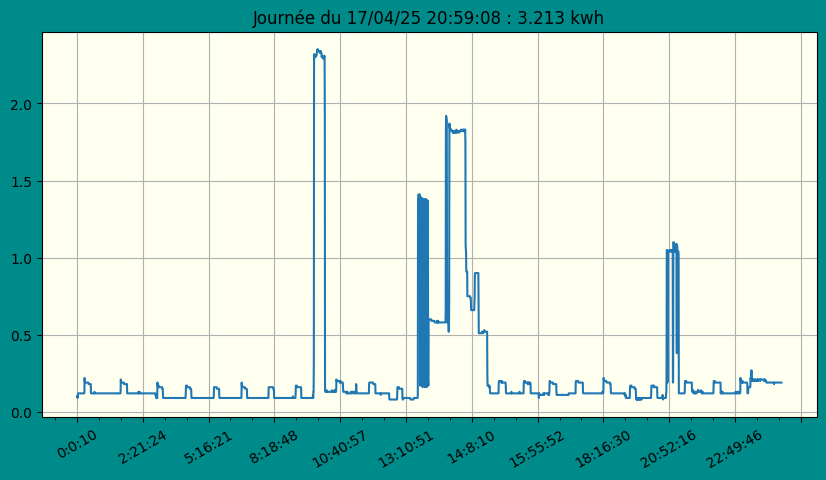

In [1715]:
show('17/04/25')

In [1716]:
end = time.time()
print(end - start)

18.146976232528687


### 1 kWh window in data of one day
#### df = conso_day

In [1717]:
df = conso_day
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
997363,18161,0.20,18.161,198.226970,26940140709,2025-07-08 00:00:02.565794,08/07/25
997364,18317,0.20,18.317,196.538735,26940159026,2025-07-08 00:00:20.882794,08/07/25
997365,18407,0.19,18.407,195.577769,26940177433,2025-07-08 00:00:39.289794,08/07/25
997366,18475,0.19,18.475,194.857916,26940195908,2025-07-08 00:00:57.764794,08/07/25
997367,18522,0.19,18.522,194.363460,26940214430,2025-07-08 00:01:16.286794,08/07/25
...,...,...,...,...,...,...,...
999995,29060,0.12,29.060,123.881624,27015557159,2025-07-08 20:56:59.015794,08/07/25
999996,29133,0.12,29.133,123.571208,27015586292,2025-07-08 20:57:28.148794,08/07/25
999997,28961,0.12,28.961,124.305100,27015615253,2025-07-08 20:57:57.109794,08/07/25
999998,28813,0.12,28.813,124.943602,27015644066,2025-07-08 20:58:25.922794,08/07/25


In [1718]:

def period(df=df, p=1):
    ''' 
    give the time of conso for a 1kWh window in a day
    p =  ordinal window ex: p=1 first kWh, p=2 second kWh ..
    df is the data from midnight, each entry is 1 watt
    as the length of df is the total conso in watt,
    we have len(df)/1000 = number of windows of 1 KWh since midnight
    the last window may not be 1000 watt long !
    '''
    if p==1:
        start = df.iloc[0].dates
    else:
        start = df.iloc[(p-1)*1000-1].dates
    if len(df)>p*1000:
        end = df.iloc[p*1000-1].dates
        conso = p*1000
    else:
        end = df.iloc[len(df)-1].dates
        conso = len(df) - (p-1)*1000
    period = end - start  # type timedelta
    hours = int(period / dt.timedelta(hours=1))
    mins = int(period / dt.timedelta(minutes=1)) - hours*60
    secs = int(period / dt.timedelta(seconds=1)) - hours*3600 - mins*60

    #df.iloc[1001:2000]['dates']#.tail(1)
    #print(period)
    print(f'{start}\t{end}\t{hours}h {mins}m {secs}s \t{conso}')


In [1719]:
df = conso_day
len(df)

2637

In [1720]:
period()  # first kWh
if len(df)>1000:
    period(p=2) # second period

2025-07-08 00:00:02.565794	2025-07-08 09:07:34.196794	9h 7m 31s 	1000
2025-07-08 09:07:34.196794	2025-07-08 15:50:06.273794	6h 42m 32s 	2000


In [1721]:
# mean of all instant conso
total_mean = conso_data[['kWh']].mean()
total_mean

kWh    0.299525
dtype: float64

In [1722]:
end = time.time()
print(end - start)

18.39852213859558


## mean for data grouped by days

In [1723]:
mean=(grouped.count()/1000).mean()
mean

kWh    3.194888
dtype: float64

In [1724]:
last=df_grp.iloc[-1]['kWh']
last

np.float64(2.637)

# conso by date


In [1725]:
# select day
day = today

#day = '16/08/24'
day

'08/07/25'

In [1726]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
997363,18161,0.20,18.161,198.226970,26940140709,2025-07-08 00:00:02.565794,08/07/25
997364,18317,0.20,18.317,196.538735,26940159026,2025-07-08 00:00:20.882794,08/07/25
997365,18407,0.19,18.407,195.577769,26940177433,2025-07-08 00:00:39.289794,08/07/25
997366,18475,0.19,18.475,194.857916,26940195908,2025-07-08 00:00:57.764794,08/07/25
997367,18522,0.19,18.522,194.363460,26940214430,2025-07-08 00:01:16.286794,08/07/25
...,...,...,...,...,...,...,...
999995,29060,0.12,29.060,123.881624,27015557159,2025-07-08 20:56:59.015794,08/07/25
999996,29133,0.12,29.133,123.571208,27015586292,2025-07-08 20:57:28.148794,08/07/25
999997,28961,0.12,28.961,124.305100,27015615253,2025-07-08 20:57:57.109794,08/07/25
999998,28813,0.12,28.813,124.943602,27015644066,2025-07-08 20:58:25.922794,08/07/25


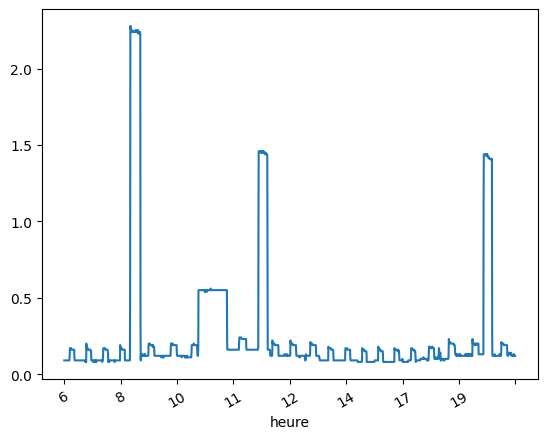

In [1727]:
conso_day=conso_data[conso_data['days']==day].copy()  # no more error
conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)) #+':'+str(x.minute) +':'+str(x.second))
#=[x.hour for x in conso_day['dates']]
df3= conso_day.set_index('heure')
df3.tail(2000)['kWh'].plot()
plt.xticks(rotation=30);
#conso_day['heure']


In [1728]:
end = time.time()
print(end - start)

18.96230125427246


### grouped by 'heure'

In [1729]:
conso_day.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2637 entries, 997363 to 999999
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   2637 non-null   int64         
 1   kWh        2637 non-null   float64       
 2   sec        2637 non-null   float64       
 3   Wh         2637 non-null   float64       
 4   cumul(ms)  2637 non-null   int64         
 5   dates      2637 non-null   datetime64[ns]
 6   days       2637 non-null   object        
 7   heure      2637 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 185.4+ KB


In [1730]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
997363,18161,0.20,18.161,198.226970,26940140709,2025-07-08 00:00:02.565794,08/07/25
997364,18317,0.20,18.317,196.538735,26940159026,2025-07-08 00:00:20.882794,08/07/25
997365,18407,0.19,18.407,195.577769,26940177433,2025-07-08 00:00:39.289794,08/07/25
997366,18475,0.19,18.475,194.857916,26940195908,2025-07-08 00:00:57.764794,08/07/25
997367,18522,0.19,18.522,194.363460,26940214430,2025-07-08 00:01:16.286794,08/07/25
...,...,...,...,...,...,...,...
999995,29060,0.12,29.060,123.881624,27015557159,2025-07-08 20:56:59.015794,08/07/25
999996,29133,0.12,29.133,123.571208,27015586292,2025-07-08 20:57:28.148794,08/07/25
999997,28961,0.12,28.961,124.305100,27015615253,2025-07-08 20:57:57.109794,08/07/25
999998,28813,0.12,28.813,124.943602,27015644066,2025-07-08 20:58:25.922794,08/07/25


In [1731]:
# group by hour, df  = data of a chosen day
df_byhour = df3[['days','kWh']].groupby('heure', sort=False)
df_byhour.groups

{'0': ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', ...], '1': ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '

In [1732]:
kwh_byhour = df_byhour['kWh']
kwh_byhour.count()

heure
0     116
1      99
2     107
3      98
4     113
5     100
6      98
7     108
8     145
9     131
10    203
11    234
12    140
13    117
14    110
15     94
16    101
17     99
18    113
19    139
20    172
Name: kWh, dtype: int64

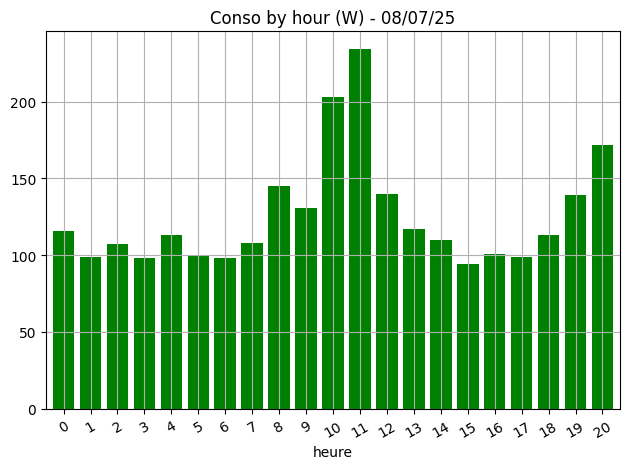

In [1733]:
kwh_byhour.count().plot(grid=True, kind='bar',color='green',width=.8)
plt.title(f'Conso by hour (W) - {day}')
plt.xticks(rotation=30);
plt.tight_layout()

In [1734]:
df_grp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 313 entries, 30/08/24 to 08/07/25
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     313 non-null    float64
dtypes: float64(1)
memory usage: 4.9+ KB


In [1735]:
# give the periods of 1 kwh in a day
period()

2025-07-08 00:00:02.565794	2025-07-08 09:07:34.196794	9h 7m 31s 	1000


In [1736]:

# premier kWh
if len(df)>1000:
    df.iloc[1000]['dates']
    df.iloc[0].dates, df.iloc[1000].dates
#df.dates.dt.time


In [1737]:

# save data
# df_grp.to_csv('df_grp.csv')
# df.to_csv('df.csv')
df_grp.to_csv('conso_day_from_20230821.csv')

#df.info()
#df_grp


In [1738]:
df_grp.mean()


kWh    3.194888
dtype: float64

In [1739]:
df_grp.head()


,kWh
days,
30/08/24,2.900
31/08/24,3.708
01/09/24,3.542
02/09/24,3.629
03/09/24,3.516


In [1740]:
df_grp.tail()


,kWh
days,
04/07/25,3.832
05/07/25,3.073
06/07/25,3.095
07/07/25,3.130
08/07/25,2.637


In [1741]:
end = time.time()
print(end - start)

20.017528295516968


# plot les 100 derniers jours


In [1742]:
# moyenne sur 100 jours
df_grp.tail(100).mean()


kWh    3.014
dtype: float64

Text(0.5, 1.0, 'Conso (kWh) last 100 days')

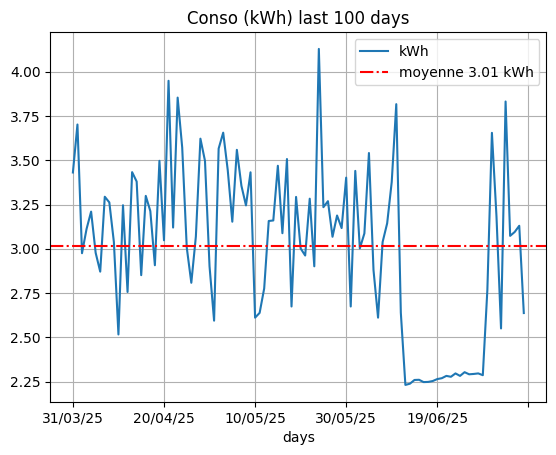

In [1743]:
# plot last 100 days
df_100 = df_grp.tail(100)
df_100.plot()
plt.axhline(y=np.nanmean(df_100),c='red', ls='-.',label=f'moyenne {np.nanmean(df_100):.2f} kWh')
plt.grid()
plt.legend()
plt.title('Conso (kWh) last 100 days')


In [1744]:
# max min during last 100 days
df_100.describe().loc[['min','max']]


,kWh
min,2.231
max,4.129


In [1745]:
end = time.time()
print(end - start)

20.88449740409851


In [1746]:
df_grp[-31:-1].index[0],df_grp[-31:-1].index[-5]

('08/06/25', '03/07/25')

In [1747]:
moyenne = df_grp.iloc[-31:-1].mean()
moyenne

kWh    2.637967
dtype: float64

Text(0.5, 1.0, 'Last month conso by day')

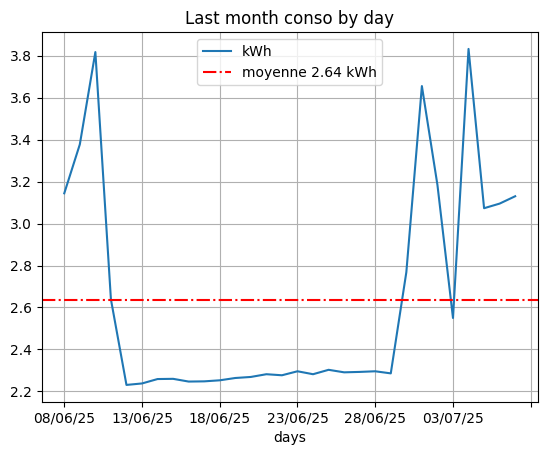

In [1748]:
# plot last monthh
df_grp.iloc[-31:-1].plot()
plt.axhline(y=np.nanmean(df_grp.iloc[-31:-1]),c='red', ls='-.',label=f'moyenne {np.nanmean(df_grp.iloc[-31:-1]):.2f} kWh')  
plt.legend()
plt.grid()
plt.title('Last month conso by day')


In [1749]:
month = df_grp.iloc[-31:-1]['kWh']
print('Max :',month.idxmax(), max(month))
print('Min :',month.idxmin(), min(month))

Max : 04/07/25 3.832
Min : 12/06/25 2.231


# Temps de conso par tranche de 1 kWh

In [1750]:
def show_tranches():    # temps de conso par tranches de 1kwh
    tranches = len(df)//1000
    print(tranches+1)
    for p in range(1,tranches+2):  # les 5 tranches de kWh consommés
        if len(df)>(p-1)*1000:
            period(p=p)

show_tranches()


3
2025-07-08 00:00:02.565794	2025-07-08 09:07:34.196794	9h 7m 31s 	1000
2025-07-08 09:07:34.196794	2025-07-08 15:50:06.273794	6h 42m 32s 	2000
2025-07-08 15:50:06.273794	2025-07-08 20:58:54.700794	5h 8m 48s 	637


In [1751]:
# conso temps réel
here = now.strftime('%H:%M:%S')
conso_jour=len(df['kWh'])
here, len(df)/1000, conso_jour


('20:59:08', 2.637, 2637)

In [1752]:
#add hours column for a chosen day
conso_hours = conso_day.copy()
conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
conso_hours.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2637 entries, 997363 to 999999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   2637 non-null   int64         
 1   kWh        2637 non-null   float64       
 2   sec        2637 non-null   float64       
 3   Wh         2637 non-null   float64       
 4   cumul(ms)  2637 non-null   int64         
 5   dates      2637 non-null   datetime64[ns]
 6   days       2637 non-null   object        
 7   heure      2637 non-null   object        
 8   hours      2637 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 206.0+ KB


In [1753]:
conso_hours['heure'], conso_hours['hours']

(997363     0
 997364     0
 997365     0
 997366     0
 997367     0
           ..
 999995    20
 999996    20
 999997    20
 999998    20
 999999    20
 Name: heure, Length: 2637, dtype: object,
 997363    00
 997364    00
 997365    00
 997366    00
 997367    00
           ..
 999995    20
 999996    20
 999997    20
 999998    20
 999999    20
 Name: hours, Length: 2637, dtype: object)

In [1754]:
end = time.time()
print(end - start)

21.76570773124695


# select number of days to display


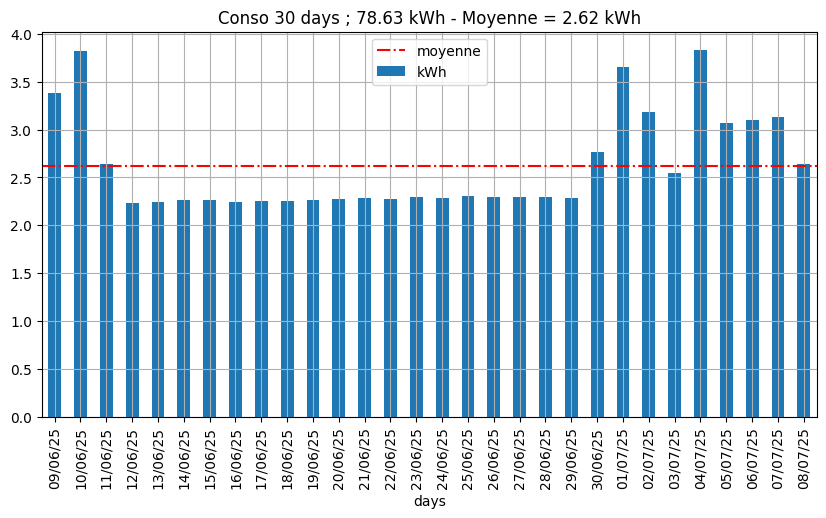

In [1755]:
span = 30
conso_mois = round(df_grp.tail(span)['kWh'].sum(),2)

# Plot the figure without labels
moy = round(np.nanmean(df_grp.tail(span)),2)
#conso_mois = sum(df_grp.tail(span)['kWh'])
df_grp.tail(span).plot.bar(grid=True, figsize=(10, 5), layout='tight')
 
plt.title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
plt.xticks(rotation=90);


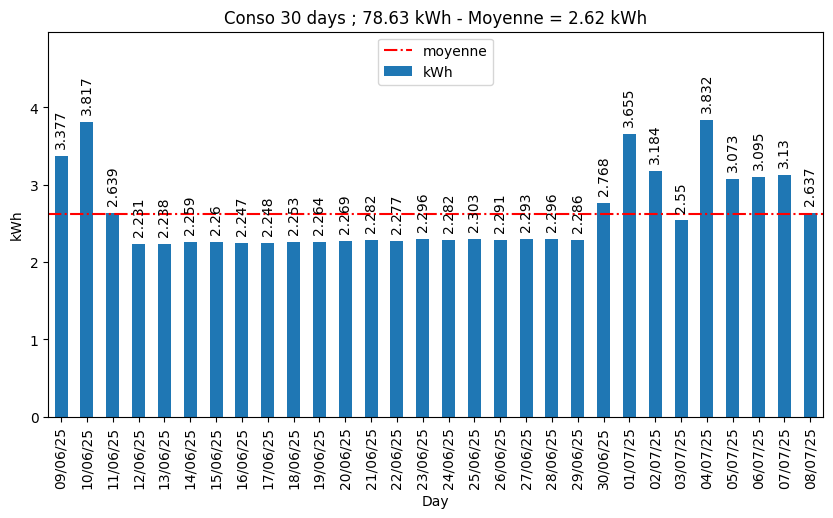

In [1756]:
# Plot the figure with labels.
x_labels = list(df_grp.tail(span)['kWh'])
#x_labels
#fig, ax = plt.subplots(figsize=(2, 2), facecolor='lightskyblue',layout='constrained')
ax = df_grp.tail(span).plot(kind="bar", figsize=(10, 5), layout='tight')
#ax.set_title(f"Conso by {span} days")
ax.set_title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
ax.set_xlabel("Day")
ax.set_ylabel("kWh")
ax.set_ymargin(0.3)
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
#ax.set_xticklabels(x_labels)
#fig.tight_layout()

rects = ax.patches

# Make some labels.
labels = [x_labels[i] for i in range(len(x_labels))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    #print(height)
    ax.text(
        rect.get_x() + rect.get_width() / 2, height+.1, label, ha="center", va="bottom", rotation=90
    )

#plt.show()

In [1757]:
y_labels = df_grp.tail(span)['kWh']
y_labels

days
09/06/25    3.377
10/06/25    3.817
11/06/25    2.639
12/06/25    2.231
13/06/25    2.238
14/06/25    2.259
15/06/25    2.260
16/06/25    2.247
17/06/25    2.248
18/06/25    2.253
19/06/25    2.264
20/06/25    2.269
21/06/25    2.282
22/06/25    2.277
23/06/25    2.296
24/06/25    2.282
25/06/25    2.303
26/06/25    2.291
27/06/25    2.293
28/06/25    2.296
29/06/25    2.286
30/06/25    2.768
01/07/25    3.655
02/07/25    3.184
03/07/25    2.550
04/07/25    3.832
05/07/25    3.073
06/07/25    3.095
07/07/25    3.130
08/07/25    2.637
Name: kWh, dtype: float64

In [1758]:
x_labels=df_grp.tail(span).index
x_labels

Index(['09/06/25', '10/06/25', '11/06/25', '12/06/25', '13/06/25', '14/06/25',
       '15/06/25', '16/06/25', '17/06/25', '18/06/25', '19/06/25', '20/06/25',
       '21/06/25', '22/06/25', '23/06/25', '24/06/25', '25/06/25', '26/06/25',
       '27/06/25', '28/06/25', '29/06/25', '30/06/25', '01/07/25', '02/07/25',
       '03/07/25', '04/07/25', '05/07/25', '06/07/25', '07/07/25', '08/07/25'],
      dtype='object', name='days')

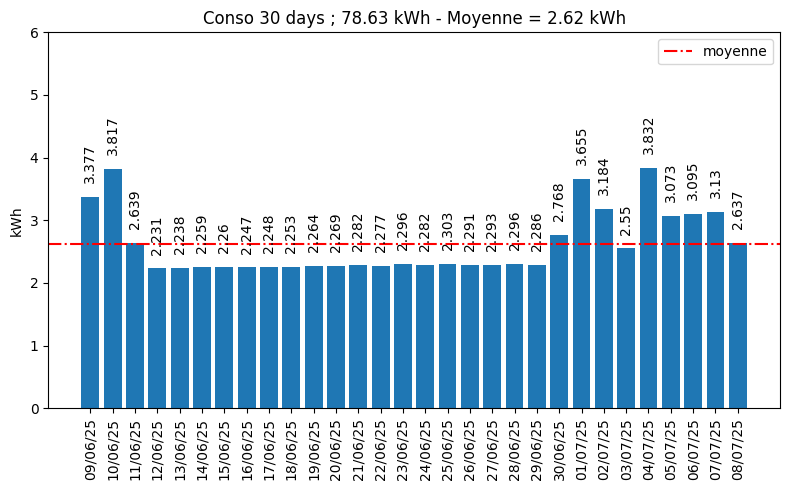

In [1759]:
# Plot the figure with labels
# using bar_label
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html#sphx-glr-gallery-lines-bars-and-markers-bar-label-demo-py
fig, ax = plt.subplots(figsize=(8, 5), layout='tight')
bar_container = ax.bar(x_labels, y_labels)
#ax.set_xticks(x_labels, rotation=45)
#ax.set_title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
ax.bar_label(bar_container, rotation=90, padding=10) #, fmt='{:,.0f}')
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
ax.set(ylabel='kWh', title=f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh', ylim=(0, 6))
plt.xticks(rotation=90);


In [1760]:
end = time.time()
print(end - start)

25.002042293548584


In [1761]:
# figure manager

current=plt.get_current_fig_manager()
current.set_window_title('Conso by day')
#help(current.canvas)
#,facecolor='darkcyan')
#plt.style.use('fivethirtyeight')
#plt.style.use('ggplot')
#plt.style.use('dark_background')


<Figure size 640x480 with 0 Axes>

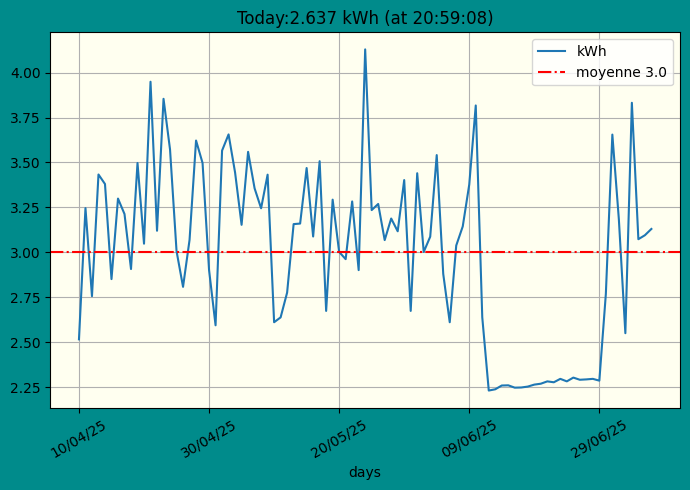

In [1762]:
# 3 last months
scan = 90
# pandas plot the day consos in the group
fig, ax = plt.subplots(facecolor='darkcyan', figsize=(7, 5), layout='tight')  # as argument
#or fig.patch.set_facecolor('darkcyan') # This changes the grey to white
ax.set_facecolor("ivory")

moy = round(np.nanmean(df_grp.iloc[-scan:-1]),2)
df_grp.iloc[-scan:-1].plot(grid=True,ax=ax, y=["kWh"])   #df.plot(x="Name", y=["Age", "Height(in cm)"], kind="bar", ax=ax)
plt.title(f'Today:{last} kWh (at {here})')
plt.axhline(y=moy,c='red', ls='-.',label=f'moyenne {moy}')
plt.legend()
plt.xticks(rotation=30);  # https://ipython.readthedocs.io/en/stable/interactive/tips.html


Text(0.5, 1.0, 'Variations journalières')

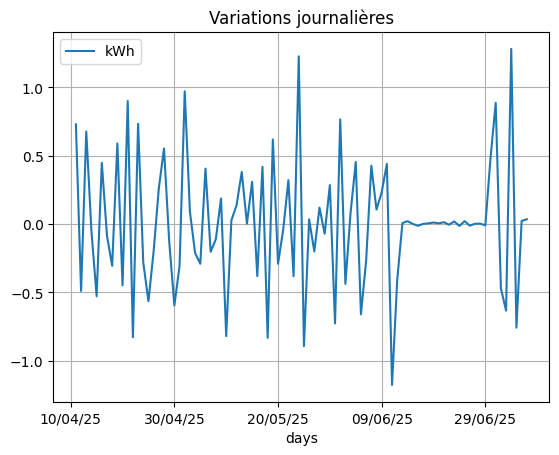

In [1763]:
# variations journalières sur 60 jours
df_grp.iloc[-scan:-1].diff().plot(grid=True)
plt.title('Variations journalières')

In [1764]:
end = time.time()
print(end - start)

25.964975118637085


# Data from 21/08/23

In [1765]:
# add hours column for conso_data (from 21/08/2023)
conso_days = conso_data.copy()
conso_days['hours']= conso_days['dates'].dt.strftime('%H')

conso_days['months']= conso_days['dates'].dt.strftime('%Y-%m')
conso_days['day']= conso_days['dates'].dt.strftime('%d')
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,26784,0.13,26.784,134.408602,26784,2024-08-30 04:38:08.640794,30/08/24,04,2024-08,30
1,26736,0.13,26.736,134.649910,53520,2024-08-30 04:38:35.376794,30/08/24,04,2024-08,30
2,26795,0.13,26.795,134.353424,80315,2024-08-30 04:39:02.171794,30/08/24,04,2024-08,30
3,26771,0.13,26.771,134.473871,107086,2024-08-30 04:39:28.942794,30/08/24,04,2024-08,30
4,26778,0.13,26.778,134.438718,133864,2024-08-30 04:39:55.720794,30/08/24,04,2024-08,30
...,...,...,...,...,...,...,...,...,...,...
999995,29060,0.12,29.060,123.881624,27015557159,2025-07-08 20:56:59.015794,08/07/25,20,2025-07,08
999996,29133,0.12,29.133,123.571208,27015586292,2025-07-08 20:57:28.148794,08/07/25,20,2025-07,08
999997,28961,0.12,28.961,124.305100,27015615253,2025-07-08 20:57:57.109794,08/07/25,20,2025-07,08
999998,28813,0.12,28.813,124.943602,27015644066,2025-07-08 20:58:25.922794,08/07/25,20,2025-07,08


In [1766]:
end = time.time()
print(end - start)

60.87586212158203


In [1767]:
conso_grouped_by_month = conso_days[['day','hours','months','kWh']].groupby('months', sort=False)

conso_grouped_by_month.groups.keys()

dict_keys(['2024-08', '2024-09', '2024-10', '2024-11', '2024-12', '2025-01', '2025-02', '2025-03', '2025-04', '2025-05', '2025-06', '2025-07'])

# define month to show

Text(0.5, 1.0, 'Conso by day (W) (2025-04)')

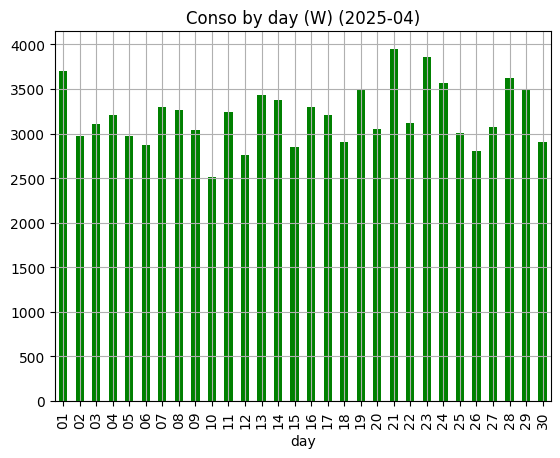

In [1768]:
m = '2025-04'
month=conso_grouped_by_month.get_group(m)
conso_grouped_by_month_day = month.groupby(['day'], sort=False)
conso_grouped_by_month_day['kWh'].count().plot(grid=True,kind='bar',color='green',width=.5)
plt.title(f'Conso by day (W) ({m})')

In [1769]:
c=conso_grouped_by_month_day['hours'].count()
c.mean()


np.float64(3199.5333333333333)

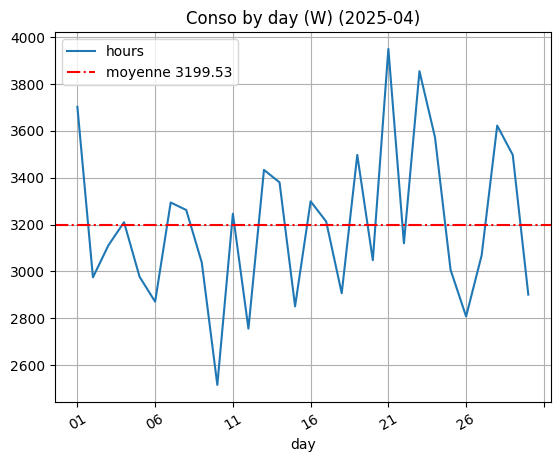

In [1770]:
conso_grouped_by_month_day['hours'].count().plot(grid=True)#, kind='bar', color='green', width=.8)
moy = round(c.mean(),2)
plt.axhline(y=moy,c='red', ls='-.',label=f'moyenne {moy}')
plt.legend()
plt.title(f'Conso by day (W) ({month.iloc[0]['months']})')
plt.xticks(rotation=30);


In [1771]:
conso_grouped_by_month_and_day = conso_days[['day','hours','months','kWh']].groupby(['months','day'], sort=False)

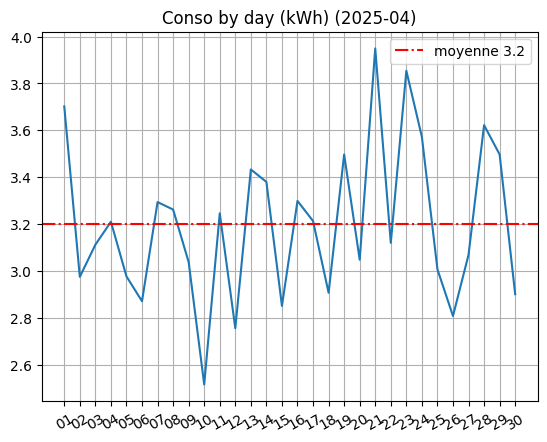

In [1772]:
plt.plot(conso_grouped_by_month_day['kWh'].count()/1000)
plt.grid()
moy = round(c.mean()/1000,2)
plt.axhline(y=moy,c='red', ls='-.',label=f'moyenne {moy}')
plt.legend()
plt.title(f'Conso by day (kWh) ({month.iloc[0]['months']})')
plt.xticks(rotation=30);

In [1773]:
# Example: Get data for January 2025 at hour '00'
#group = conso_grouped_by_month_and_day.get_group('2025-01')
#group

In [1774]:
# group.plot(grid=True, kind='bar', color='green', width=.8)
# plt.title('Conso by hour (W) - 2025-01')
# plt.xticks(rotation=30);


In [1775]:
# conso total par mois
conso_grouped_by_month.count()


,day,hours,kWh
months,,,
2024-08,6608,6608,6608
2024-09,69935,69935,69935
2024-10,73331,73331,73331
2024-11,108184,108184,108184
2024-12,113984,113984,113984
2025-01,113860,113860,113860
2025-02,104306,104306,104306
2025-03,111823,111823,111823
2025-04,95986,95986,95986


In [1776]:
# example groupby with apply
df2 = pd.DataFrame({'Animal': ['Falcon', 'Falcon',
                              'Parrot', 'Parrot'],
                   'Max Speed': [380., 370., 24., 26.]})
df2.groupby("Animal", group_keys=True)[['Max Speed']].apply(lambda x: x)
      

Max Speed
Animal             
Falcon 0      380.0
       1      370.0
Parrot 2       24.0
       3       26.0

In [1777]:
# import pandas as pd
# df = pd.read_csv(r'../csv/only-bh-extreme-events-satellite.csv'
#                   ,index_col=[0,1,2,3,4]
#                   ,header=[0,1,2,3]
#                   ,skipinitialspace=True
#                   #,tupleize_cols=True
#                 ) 

# df.columns = pd.MultiIndex.from_tuples(df.columns)
# df.index.names
# index=df.columns.levels[0]
# index
# df_des = pd.DataFrame(
#                             index=df.columns.levels[0],
#                             columns=['count','mean','std','min','25','50','75','max']
#                          )
# df_des

In [1778]:
groupallbyday = conso_days[['days','hours','kWh']].groupby(['days'], sort=False)
groupallbyday[['kWh']].count()  #.apply(lambda x: x))

,kWh
days,
30/08/24,2900
31/08/24,3708
01/09/24,3542
02/09/24,3629
03/09/24,3516
...,...
04/07/25,3832
05/07/25,3073
06/07/25,3095


In [1779]:
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,26784,0.13,26.784,134.408602,26784,2024-08-30 04:38:08.640794,30/08/24,04,2024-08,30
1,26736,0.13,26.736,134.649910,53520,2024-08-30 04:38:35.376794,30/08/24,04,2024-08,30
2,26795,0.13,26.795,134.353424,80315,2024-08-30 04:39:02.171794,30/08/24,04,2024-08,30
3,26771,0.13,26.771,134.473871,107086,2024-08-30 04:39:28.942794,30/08/24,04,2024-08,30
4,26778,0.13,26.778,134.438718,133864,2024-08-30 04:39:55.720794,30/08/24,04,2024-08,30
...,...,...,...,...,...,...,...,...,...,...
999995,29060,0.12,29.060,123.881624,27015557159,2025-07-08 20:56:59.015794,08/07/25,20,2025-07,08
999996,29133,0.12,29.133,123.571208,27015586292,2025-07-08 20:57:28.148794,08/07/25,20,2025-07,08
999997,28961,0.12,28.961,124.305100,27015615253,2025-07-08 20:57:57.109794,08/07/25,20,2025-07,08
999998,28813,0.12,28.813,124.943602,27015644066,2025-07-08 20:58:25.922794,08/07/25,20,2025-07,08


In [1780]:

# group all by day for all conso_days
groupallbydayhours = conso_days[['days','hours','kWh']].groupby(['days','hours'], sort=False)
# use apply to show the group
groupallbydayhours[['days','hours','kWh']].apply(lambda x: x)


days hours   kWh
days     hours                             
30/08/24 04    0       30/08/24    04  0.13
               1       30/08/24    04  0.13
               2       30/08/24    04  0.13
               3       30/08/24    04  0.13
               4       30/08/24    04  0.13
...                         ...   ...   ...
08/07/25 20    999995  08/07/25    20  0.12
               999996  08/07/25    20  0.12
               999997  08/07/25    20  0.12
               999998  08/07/25    20  0.12
               999999  08/07/25    20  0.12

[1000000 rows x 3 columns]

In [1781]:
groupallbyday.indices.keys()

dict_keys(['30/08/24', '31/08/24', '01/09/24', '02/09/24', '03/09/24', '04/09/24', '05/09/24', '06/09/24', '07/09/24', '08/09/24', '09/09/24', '10/09/24', '11/09/24', '12/09/24', '13/09/24', '14/09/24', '15/09/24', '16/09/24', '17/09/24', '18/09/24', '19/09/24', '20/09/24', '21/09/24', '22/09/24', '23/09/24', '24/09/24', '25/09/24', '26/09/24', '27/09/24', '28/09/24', '29/09/24', '30/09/24', '01/10/24', '02/10/24', '03/10/24', '04/10/24', '05/10/24', '06/10/24', '07/10/24', '08/10/24', '09/10/24', '10/10/24', '11/10/24', '12/10/24', '13/10/24', '14/10/24', '15/10/24', '16/10/24', '17/10/24', '18/10/24', '19/10/24', '20/10/24', '21/10/24', '22/10/24', '23/10/24', '24/10/24', '25/10/24', '26/10/24', '27/10/24', '28/10/24', '29/10/24', '30/10/24', '31/10/24', '01/11/24', '02/11/24', '03/11/24', '04/11/24', '05/11/24', '06/11/24', '07/11/24', '08/11/24', '09/11/24', '10/11/24', '11/11/24', '12/11/24', '13/11/24', '14/11/24', '15/11/24', '16/11/24', '17/11/24', '18/11/24', '19/11/24', '20/1

In [1782]:
groupallbydayhours.indices.keys()

dict_keys([('30/08/24', '04'), ('30/08/24', '05'), ('30/08/24', '06'), ('30/08/24', '07'), ('30/08/24', '08'), ('30/08/24', '09'), ('30/08/24', '10'), ('30/08/24', '11'), ('30/08/24', '12'), ('30/08/24', '13'), ('30/08/24', '14'), ('30/08/24', '15'), ('30/08/24', '16'), ('30/08/24', '17'), ('30/08/24', '18'), ('30/08/24', '19'), ('30/08/24', '20'), ('30/08/24', '21'), ('30/08/24', '22'), ('30/08/24', '23'), ('31/08/24', '04'), ('31/08/24', '05'), ('31/08/24', '06'), ('31/08/24', '07'), ('31/08/24', '08'), ('31/08/24', '09'), ('31/08/24', '10'), ('31/08/24', '11'), ('31/08/24', '12'), ('31/08/24', '13'), ('31/08/24', '14'), ('31/08/24', '15'), ('31/08/24', '16'), ('31/08/24', '17'), ('31/08/24', '18'), ('31/08/24', '19'), ('31/08/24', '20'), ('31/08/24', '21'), ('31/08/24', '22'), ('31/08/24', '23'), ('31/08/24', '00'), ('31/08/24', '01'), ('31/08/24', '02'), ('31/08/24', '03'), ('01/09/24', '04'), ('01/09/24', '05'), ('01/09/24', '06'), ('01/09/24', '07'), ('01/09/24', '08'), ('01/09/2

In [1783]:
grp_by_day = groupallbyday.count()
grp_by_day

,hours,kWh
days,,
30/08/24,2900,2900
31/08/24,3708,3708
01/09/24,3542,3542
02/09/24,3629,3629
03/09/24,3516,3516
...,...,...
04/07/25,3832,3832
05/07/25,3073,3073
06/07/25,3095,3095


In [1784]:
grp_by_day['kWh'].cumsum()

days
30/08/24       2900
31/08/24       6608
01/09/24      10150
02/09/24      13779
03/09/24      17295
             ...   
04/07/25     988065
05/07/25     991138
06/07/25     994233
07/07/25     997363
08/07/25    1000000
Name: kWh, Length: 313, dtype: int64

In [1785]:
grp_by_dayhours = groupallbydayhours.count()
grp_by_dayhours

kWh
days     hours     
30/08/24 04      50
         05     147
         06     129
         07     121
         08     148
...             ...
08/07/25 16     101
         17      99
         18     113
         19     139
         20     172

[7505 rows x 1 columns]

In [1786]:
grp_by_dayhours['kWh'].cumsum()

days      hours
30/08/24  04            50
          05           197
          06           326
          07           447
          08           595
                    ...   
08/07/25  16        999477
          17        999576
          18        999689
          19        999828
          20       1000000
Name: kWh, Length: 7505, dtype: int64

In [1787]:
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(level=0)['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(level=0)['kWh'].diff()
# or
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(['days'])['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(['days'])['kWh'].diff()
grp_by_dayhours

kWh  cumsum  diff
days     hours                   
30/08/24 04      50      50   NaN
         05     147     197  97.0
         06     129     326 -18.0
         07     121     447  -8.0
         08     148     595  27.0
...             ...     ...   ...
08/07/25 16     101    2114   7.0
         17      99    2213  -2.0
         18     113    2326  14.0
         19     139    2465  26.0
         20     172    2637  33.0

[7505 rows x 3 columns]

In [1788]:
today, grp_by_dayhours.loc[today]

('08/07/25',
        kWh  cumsum  diff
 hours                   
 00     116     116   NaN
 01      99     215 -17.0
 02     107     322   8.0
 03      98     420  -9.0
 04     113     533  15.0
 05     100     633 -13.0
 06      98     731  -2.0
 07     108     839  10.0
 08     145     984  37.0
 09     131    1115 -14.0
 10     203    1318  72.0
 11     234    1552  31.0
 12     140    1692 -94.0
 13     117    1809 -23.0
 14     110    1919  -7.0
 15      94    2013 -16.0
 16     101    2114   7.0
 17      99    2213  -2.0
 18     113    2326  14.0
 19     139    2465  26.0
 20     172    2637  33.0)

Text(0.5, 1.0, 'Cumul journalier')

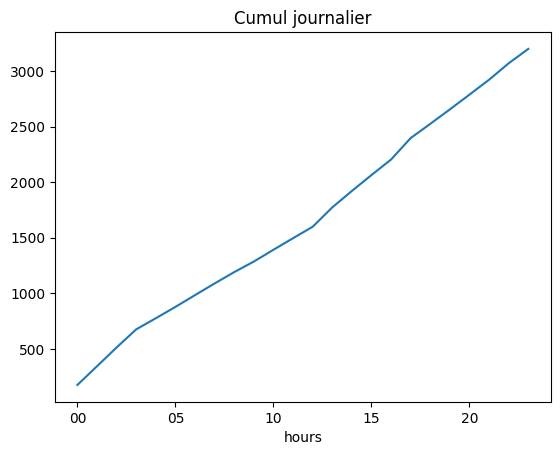

In [1789]:
# progression sans surprise
grp_by_dayhours.loc['05/11/24']['cumsum'].plot()
plt.title('Cumul journalier')

Text(0.5, 1.0, 'Variation horaire')

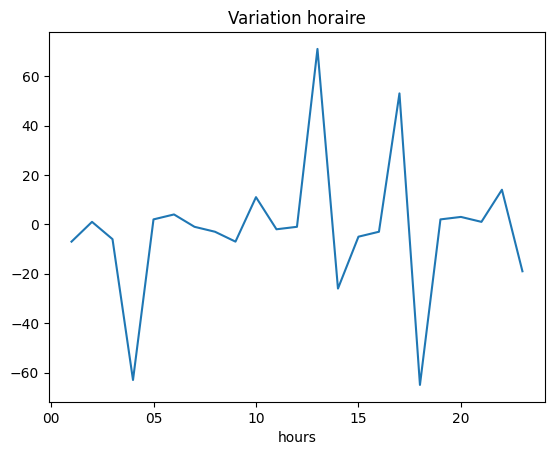

In [1790]:
# plus parlant
grp_by_dayhours.loc['05/11/24']['diff'].plot()
plt.title(r'Variation horaire')

In [1791]:
# count number of days since 21/08/2023
# https://stackoverflow.com/questions/45972388/count-my-multi-index-length-in-a-dataframe-pandas
n = len(grp_by_dayhours.index.levels[0].unique())
# or
n = len(grp_by_dayhours.index.levels[0])
# or
n = grp_by_dayhours.index.levshape[0]  # levshape -> (371,24)
n

313

In [1792]:
df_grp.tail(n)['kWh'].describe()


count    313.000000
mean       3.194888
std        0.731550
min        1.783000
25%        2.880000
50%        3.356000
75%        3.663000
max        4.735000
Name: kWh, dtype: float64

In [1793]:
maxday = df_grp.tail(n)['kWh'].idxmax()

In [1794]:
n, np.nanmean(df_grp.tail(n))

(313, np.float64(3.194888178913738))

Text(0.5, 1.0, '313 days')

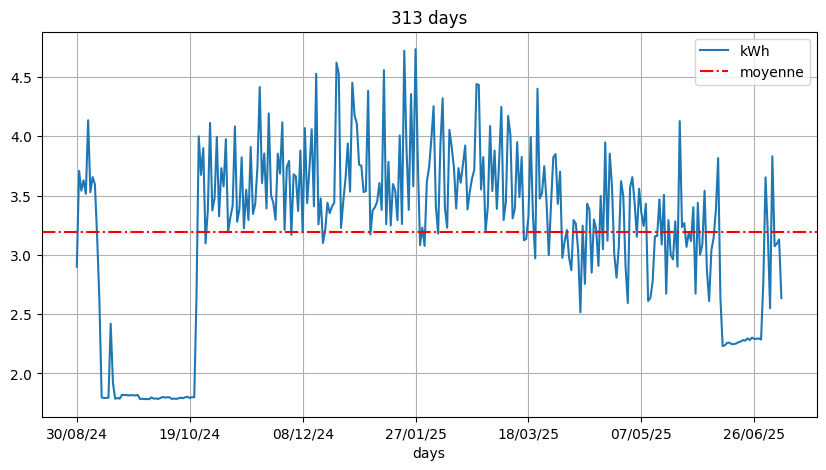

In [1795]:
# show conso in span 
span = n
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.legend()
plt.title(f'{span} days')

Text(0.5, 1.0, '100 days')

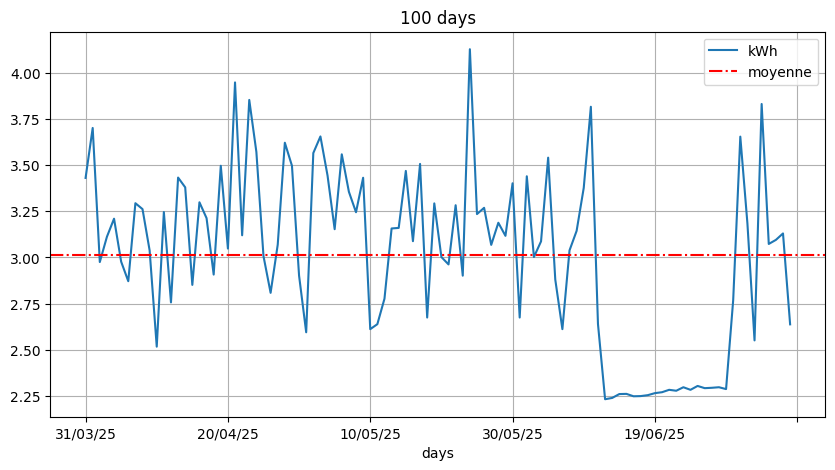

In [1796]:
# show conso in span 
span = 100
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.legend()
plt.title(f'{span} days')

In [1797]:
np.nanmean(df_grp.tail(span))

np.float64(3.0140000000000002)

In [1798]:
df_grp['kWh']

days
30/08/24    2.900
31/08/24    3.708
01/09/24    3.542
02/09/24    3.629
03/09/24    3.516
            ...  
04/07/25    3.832
05/07/25    3.073
06/07/25    3.095
07/07/25    3.130
08/07/25    2.637
Name: kWh, Length: 313, dtype: float64

In [1799]:
df_grp.describe()

,kWh
count,313.000000
mean,3.194888
std,0.731550
min,1.783000
25%,2.880000
50%,3.356000
75%,3.663000
max,4.735000


array([[<Axes: title={'center': 'kWh'}>]], dtype=object)

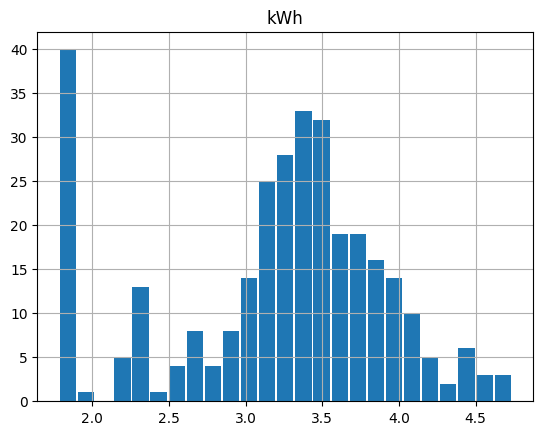

In [1800]:
# répartition des consos de 1 à 5 kWh par jour
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
# histtype{'bar', 'barstacked', 'step', 'stepfilled'}, default: 'bar'
df_grp.hist(bins=25, density=False, histtype='bar',rwidth=0.9, align='mid')

In [1801]:
df_grp.tail(span)['kWh']

days
31/03/25    3.431
01/04/25    3.702
02/04/25    2.975
03/04/25    3.112
04/04/25    3.210
            ...  
04/07/25    3.832
05/07/25    3.073
06/07/25    3.095
07/07/25    3.130
08/07/25    2.637
Name: kWh, Length: 100, dtype: float64

# Conso par heure

In [1802]:
day

'08/07/25'

In [1803]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff
hours,,,
00,116,116,NaN
01,99,215,-17.0
02,107,322,8.0
03,98,420,-9.0
04,113,533,15.0
05,100,633,-13.0
06,98,731,-2.0
07,108,839,10.0
08,145,984,37.0


In [1804]:
# select a day to plot
day = '02/07/24'
day = today
len(grp_by_dayhours.loc[day])


21

In [1805]:
l = range(1,len(grp_by_dayhours.loc[day])+1)
l

range(1, 22)

In [1806]:
grp_by_dayhours.loc[day,'days'] = l #ist(1,len(grp_by_day.loc[day])+1)

In [1807]:
grp_by_dayhours.loc[day,'days'].values

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21.])

In [1808]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
10    11.0
11    12.0
12    13.0
13    14.0
14    15.0
15    16.0
16    17.0
17    18.0
18    19.0
19    20.0
20    21.0
Name: days, dtype: float64

In [1809]:
### ????????????????????????
grp_by_dayhours.loc[day,'days'] = grp_by_dayhours.loc[day,'days'].values.astype('int64')

In [1810]:
grp_by_dayhours.loc[day].info()

<class 'pandas.core.frame.DataFrame'>
Index: 21 entries, 00 to 20
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     21 non-null     int64  
 1   cumsum  21 non-null     int64  
 2   diff    20 non-null     float64
 3   days    21 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 840.0+ bytes


In [1811]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
10    11.0
11    12.0
12    13.0
13    14.0
14    15.0
15    16.0
16    17.0
17    18.0
18    19.0
19    20.0
20    21.0
Name: days, dtype: float64

In [1812]:
day

'08/07/25'

In [1813]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff,days
hours,,,,
00,116,116,NaN,1.0
01,99,215,-17.0,2.0
02,107,322,8.0,3.0
03,98,420,-9.0,4.0
04,113,533,15.0,5.0
05,100,633,-13.0,6.0
06,98,731,-2.0,7.0
07,108,839,10.0,8.0
08,145,984,37.0,9.0


In [1814]:
kwh = grp_by_dayhours.loc[day][['kWh']]/1000
np.sum(kwh)[0]


c:\Users\jeand\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\jeand\AppData\Local\Temp\ipykernel_6040\2885532441.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.sum(kwh)[0]


np.float64(2.637)

In [1815]:
grp_by_dayhours

kWh  cumsum  diff  days
days     hours                         
30/08/24 04      50      50   NaN   NaN
         05     147     197  97.0   NaN
         06     129     326 -18.0   NaN
         07     121     447  -8.0   NaN
         08     148     595  27.0   NaN
...             ...     ...   ...   ...
08/07/25 16     101    2114   7.0  17.0
         17      99    2213  -2.0  18.0
         18     113    2326  14.0  19.0
         19     139    2465  26.0  20.0
         20     172    2637  33.0  21.0

[7505 rows x 4 columns]

c:\Users\jeand\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Text(0.5, 1.0, '08/07/25: kWh    2.637\ndtype: float64')

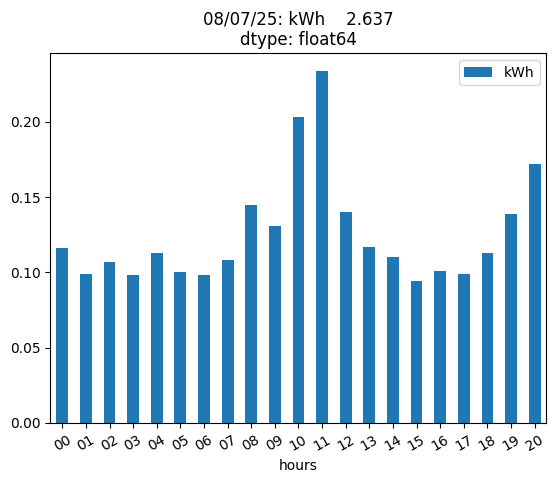

In [1816]:
kwh.plot.bar(label='watt')
plt.legend()
plt.xticks(rotation=30)
plt.title(f'{day}: {np.sum(kwh)}')

In [1817]:
grp_by_dayhours.loc[day].index

Index(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12', '13', '14', '15', '16', '17', '18', '19', '20'],
      dtype='object', name='hours')

# Conso du jour


In [1818]:
grp_by_dayhours.count()

kWh       7505
cumsum    7505
diff      7192
days        21
dtype: int64

'27/01/25'

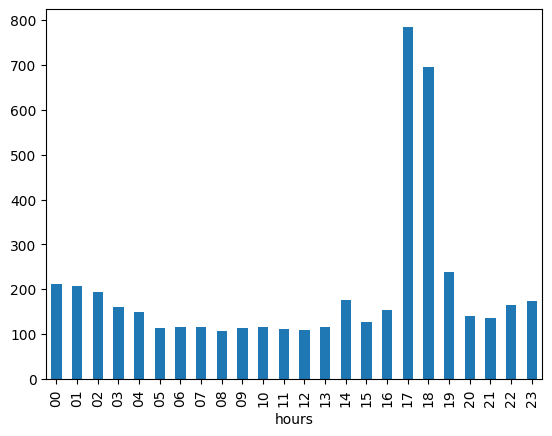

In [1819]:
#day = '09/09/24'
day = maxday
#day = today
grp_by_dayhours.loc[day].kWh.plot(kind='bar')
maxday

In [1820]:
def conso_by_hour(day):
    global data
    # conso by hour
    #data = groupedbyhour.count().kWh
    data = grp_by_dayhours.loc[day].kWh

    # len(groupedbyhour)
    x = np.arange(1,len(data)+1)
    ymax = max(data)+5
    #groupedbyhour.count().plot(grid=True,xticks=x)
    fig, ax = plt.subplots(figsize=(8, 5), facecolor='darkcyan')

    plt.bar(x,data)
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) {day} - Total {sum(data)}')
    plt.xlim(0,len(x)+1)
    #plt.xticks(rotation=30);
    #plt.ylim(0,ymax)

    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in data]
    fontfamily = {'calibri', 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 3, label, ha="center", va="bottom",
            fontfamily=fontfamily, fontsize=10, fontweight='bold', color='red'
        )


# 100 days

Total= 301.4 , Moyenne= 3.0140000000000002


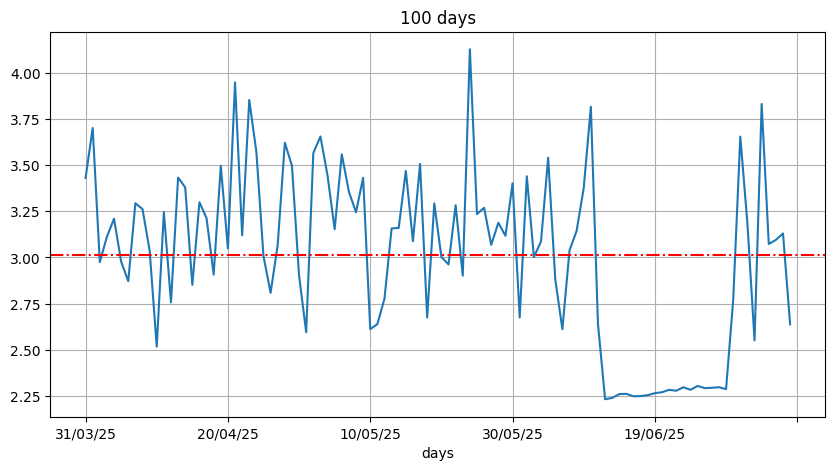

In [1821]:
# show conso in span 
span = 100
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.title(f'{span} days')

print('Total=',sum(df_grp.tail(span)['kWh']),', Moyenne=',np.nanmean(df_grp.tail(span)))

In [1822]:
from datetime import datetime

# Get the current time
current_time = datetime.now()

# Convert the time to minutes in a day
minutes_in_day = current_time.hour * 60 + current_time.minute
print(f"Current time: {current_time.strftime('%H:%M:%S')}, Minutes in day: {minutes_in_day}")

Current time: 21:00:08, Minutes in day: 1260


In [1823]:
def convert_to_min_sec(seconds):
    """
    Convert a float value in seconds to minutes and seconds.
    """
    minutes, sec = divmod(seconds, 60)
    return f'{int(minutes)}:{round(sec, 2)}'


In [1824]:
#import timeit
#start = timeit.timeit()
#print("hello")
end = time.time()
print(convert_to_min_sec(end - start))

1:16.2


In [1825]:
end - start

76.20453119277954

In [1826]:
#df = conso_day
show_tranches()

3
2025-07-08 00:00:02.565794	2025-07-08 09:07:34.196794	9h 7m 31s 	1000
2025-07-08 09:07:34.196794	2025-07-08 15:50:06.273794	6h 42m 32s 	2000
2025-07-08 15:50:06.273794	2025-07-08 20:58:54.700794	5h 8m 48s 	637


In [1827]:
df_grp.tail(7)['kWh']

days
02/07/25    3.184
03/07/25    2.550
04/07/25    3.832
05/07/25    3.073
06/07/25    3.095
07/07/25    3.130
08/07/25    2.637
Name: kWh, dtype: float64

<Axes: xlabel='days'>

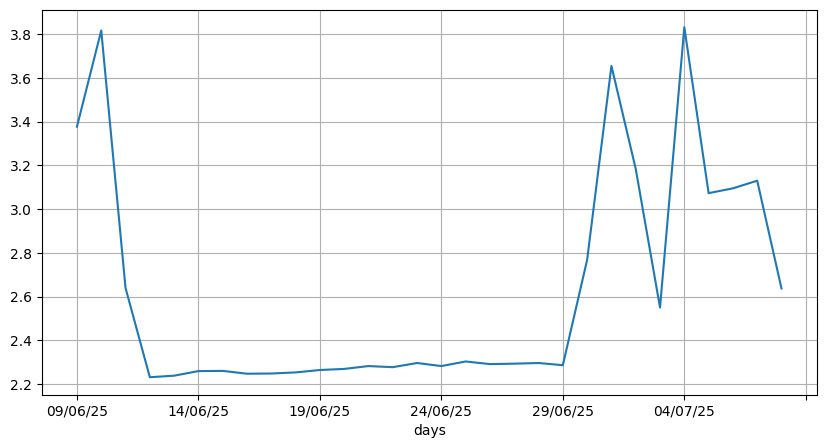

In [1828]:
df_grp.tail(30)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)

# Today

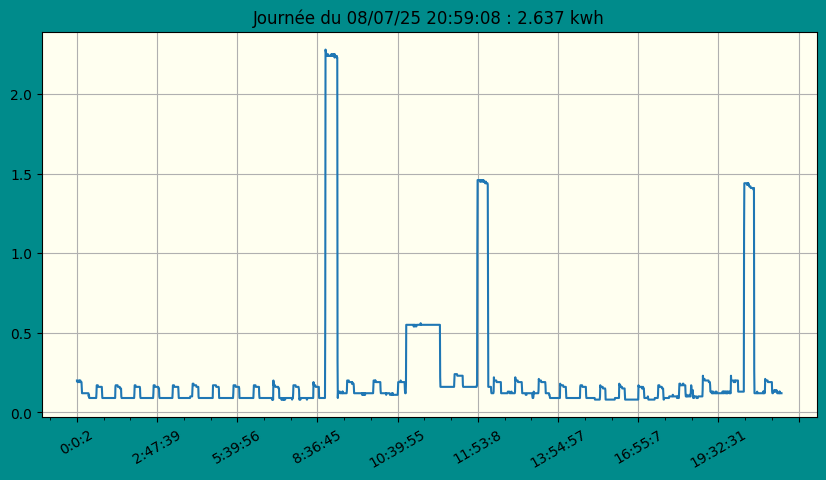

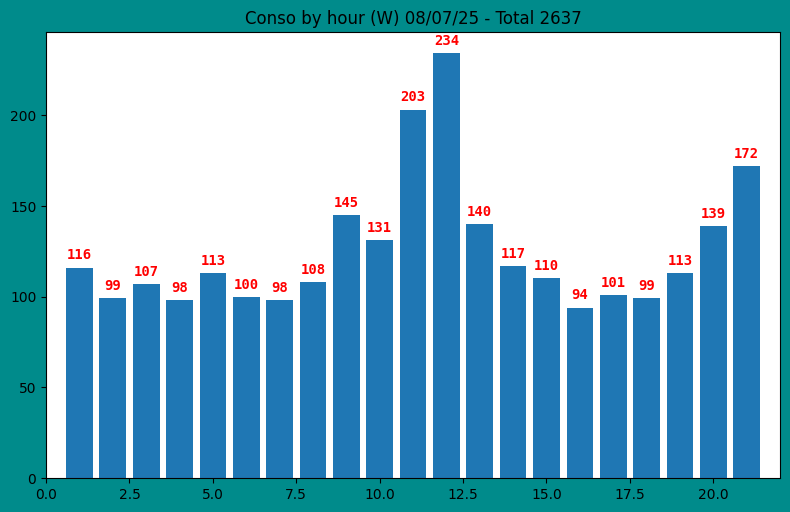

In [1829]:
show(today,bgcolor='ivory')
conso_by_hour(today)

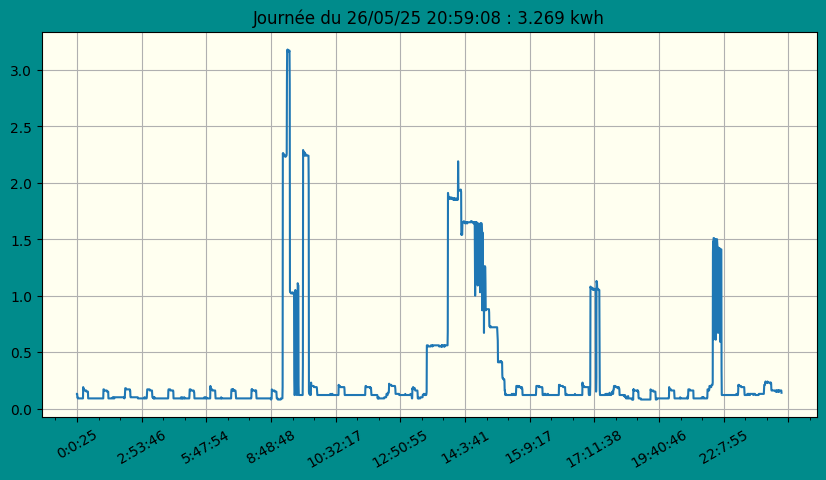

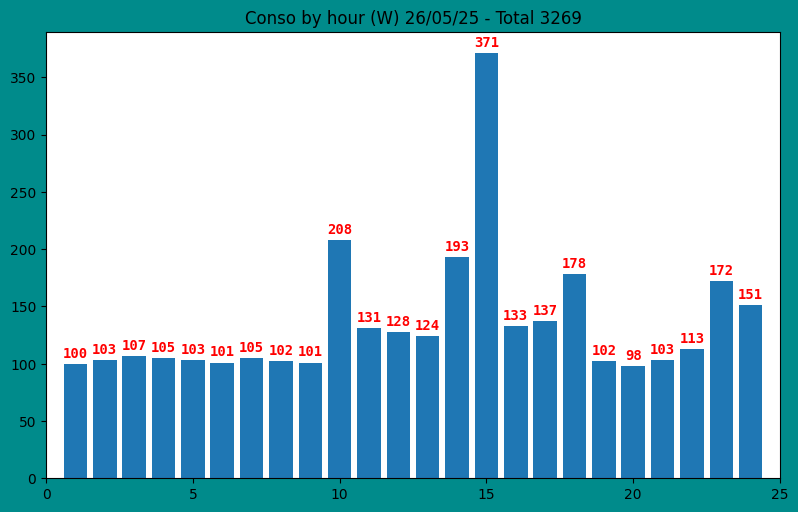

In [1830]:
# 21/04/25 cuisine midi et télé le soir 4.115 kWh
day = '26/05/25' 
day, show(day,bgcolor='ivory')
conso_by_hour(day)

27/01/25


(None, 4735)

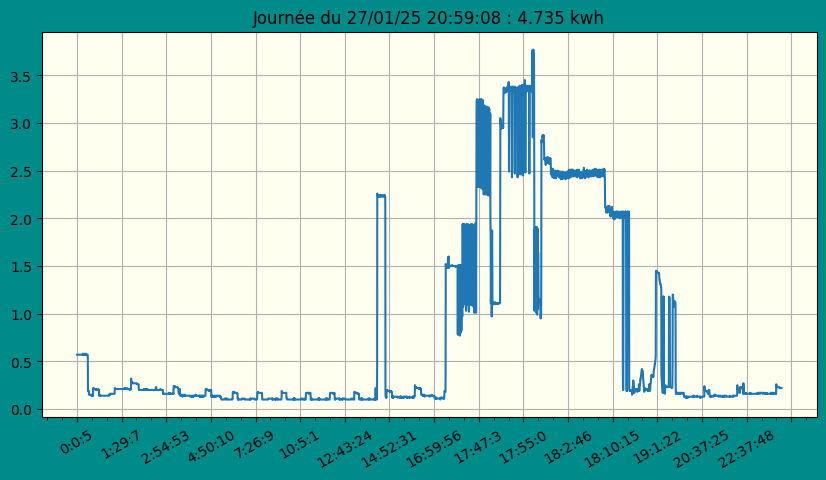

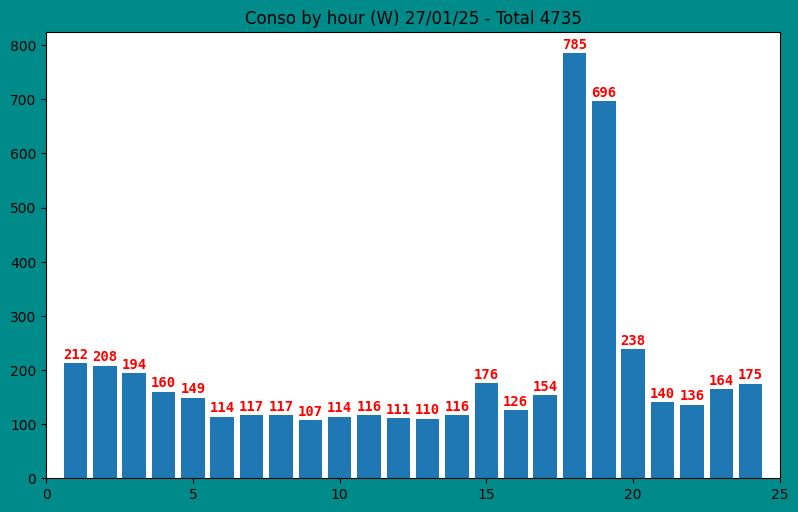

In [1831]:
print(maxday)
# retour vietnam 22/10/2024
#day = '22/10/24'
day = maxday
day, show(day,bgcolor='ivory')
conso_by_hour(day),sum(data)

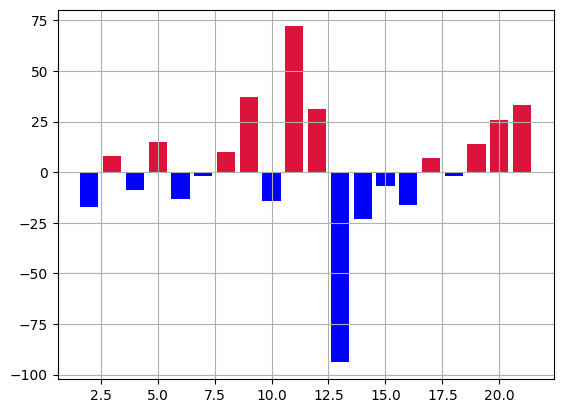

In [1832]:
diff = grp_by_dayhours.loc[today]
diff

x = np.arange(1,len(diff)+1)

plt.bar(x,diff['diff'], color=np.where(diff['diff'] > 0, 'crimson', 'blue'))
plt.grid()

<Axes: xlabel='hours'>

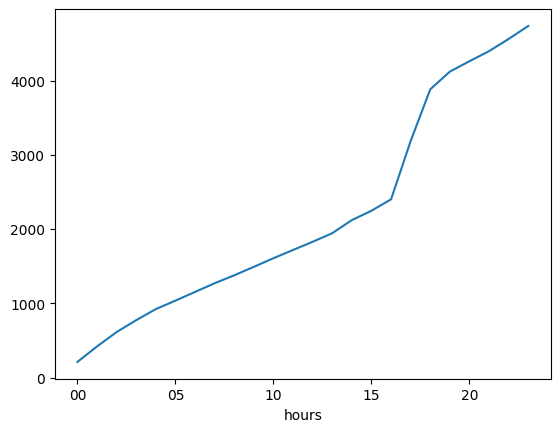

In [1833]:
data.cumsum().plot()


<Axes: xlabel='hours'>

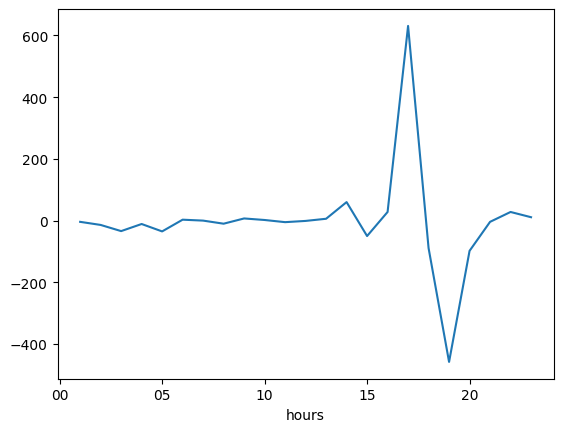

In [1834]:
# evolution par heure
data.diff().plot()

In [1835]:
data.diff().describe()

count     23.000000
mean      -1.608696
std      170.044577
min     -458.000000
25%      -24.000000
50%       -4.000000
75%        6.500000
max      631.000000
Name: kWh, dtype: float64

<Axes: >

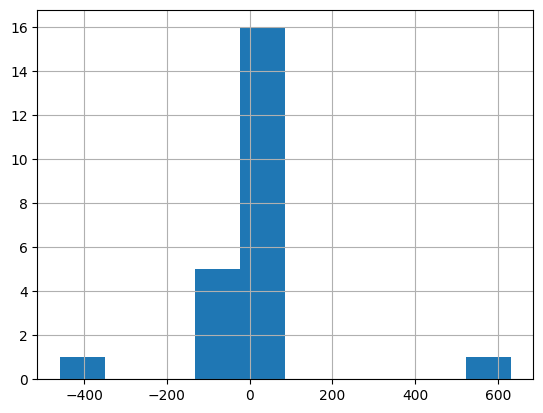

In [1836]:
data.diff().hist()

# Test sauvegarde

# list files in current directory


In [1837]:
import os
os.listdir(path='.')

['linear combination of atomic orbitals.ipynb',
 'loi_pareto.ipynb',
 'Lotka_Volterra_model.ipynb',
 'bitcoin_api.ipynb',
 'pencil_sketch.ipynb',
 'sample.json',
 'tricks.ipynb',
 'eur_vnd_change_data.ipynb',
 'pandas_course2.ipynb',
 'socket_server.ipynb',
 'tree_minmax.ipynb',
 'amlich_data.py',
 'decimals_pi_plot.ipynb',
 'conso_jour.csv',
 'Mass_Spring_Damper.jpg',
 'mills_primes.ipynb',
 'ligue1_pandas.ipynb',
 'sun_moon_paris_20250603.png',
 'isp_simulation_falcon9.ipynb',
 'primes2million.pkl',
 'socket_client.ipynb',
 'magic_tricks.ipynb',
 'magicdragon.ipynb',
 'rainbow_color.ipynb',
 'snake_game.ipynb',
 'sympy_fun.ipynb',
 'tqdm_benchmark.ipynb',
 'sun_moon_azimuth_paris_2025-06-06.png',
 'ligue1_2020_extended.txt',
 'pd_grp_plot.ipynb',
 'sun_moon_paris_20250605.png',
 'tkinter_scale_color.ipynb',
 'Dewpoint-RH-fr.svg.png',
 'read_xml.ipynb',
 'pi_from_collisions.ipynb',
 'mqtt_temp.ipynb',
 'sudoku_generator.ipynb',
 'onecall_issue.ipynb',
 'poo_chap10.ipynb',
 'de421.bsp'

# list store files csv


In [1838]:
res = []
# Iterate directory
for file in os.listdir('.'):
    # check only text files
    if file.endswith('.csv'):
        res.append(file)
        print(file)
#print(res)

conso_jour.csv
table-indicateurs-open-data-france-2023-06-30-17h59.csv
CAC40.csv
Nasdaq.csv
karaoke.csv
saturn_rings.csv
DowJones.csv
planete.csv
conso_par_jour.csv
8days.csv
SMSSpamCollection.csv
df_grp.csv
Ford.csv
Tesla.csv
Nikkei.csv
temp_humidity.csv
titanic.csv
data_temp16122022.csv
week.csv
Toyota.csv
Apple.csv
VNDUSD.csv
demain.csv
saturn_bodies.csv
conso_day_from_20230821.csv
WA_Fn-UseC_-Telco-Customer-Churn.csv
ligue1_2020_27.csv
table-indicateurs-open-data-dep-2023-06-30-17h59.csv
conso_data.csv
EURUSD.csv
df.csv


('27/01/25', None)

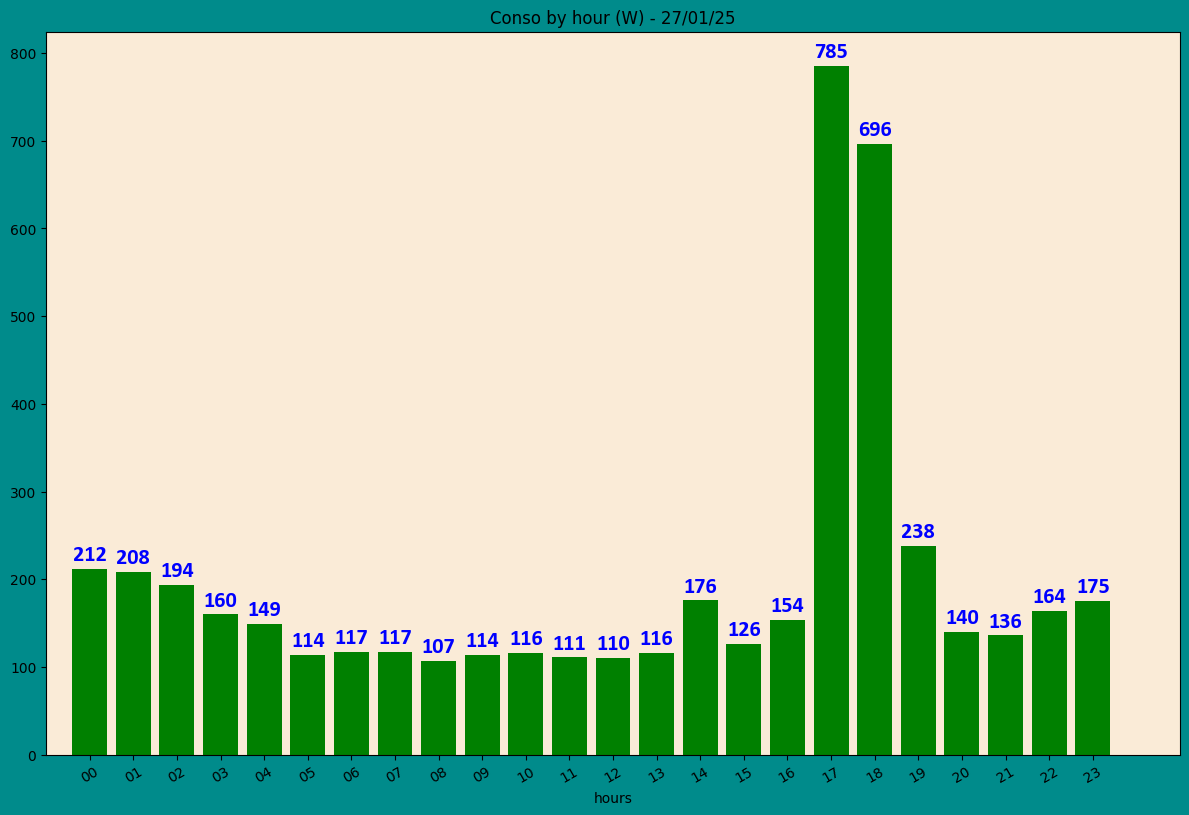

In [1839]:
day,conso_byhour(day)

In [1840]:
# save to file
import pickle
path = r'../consobyhour.pkl'
with open(path,'wb') as file:
    pickle.dump(data, file)

# plot any day


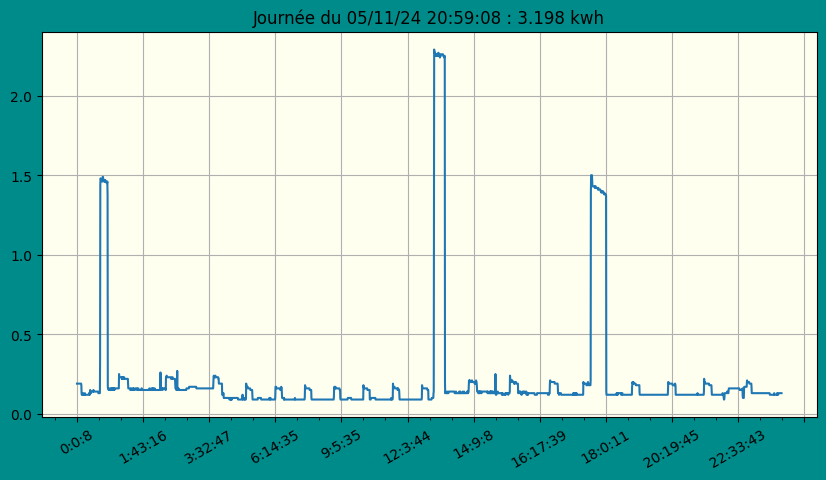

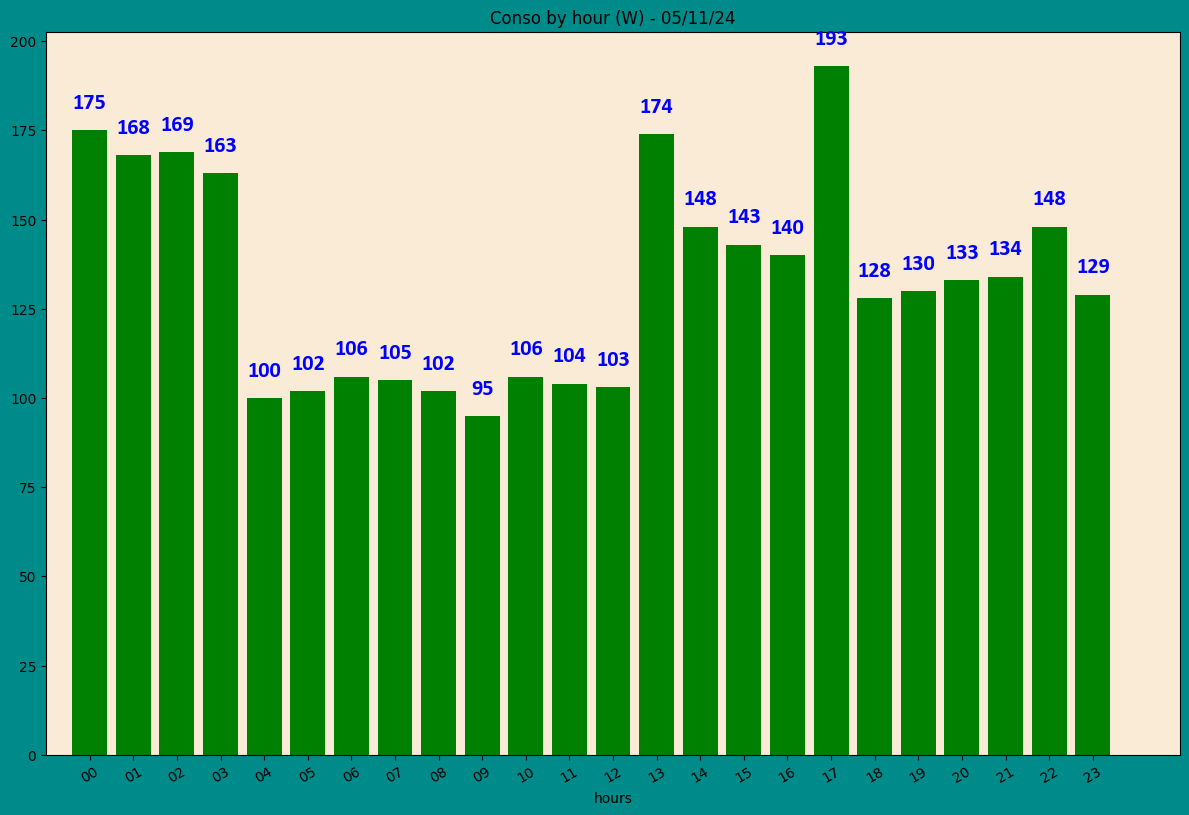

In [1841]:
day = '05/11/24'
#day = today
show(day,pltcolor='darkcyan')
conso_byhour(day)

In [1842]:
month

,day,hours,months,kWh
702031,01,00,2025-04,0.32
702032,01,00,2025-04,0.28
702033,01,00,2025-04,0.28
702034,01,00,2025-04,0.28
702035,01,00,2025-04,0.28
...,...,...,...,...
798012,30,23,2025-04,0.15
798013,30,23,2025-04,0.15
798014,30,23,2025-04,0.15
798015,30,23,2025-04,0.15


In [1843]:
month.describe()


,kWh
count,95986.000000
mean,0.310187
std,0.547418
min,0.080000
25%,0.090000
50%,0.120000
75%,0.180000
max,3.790000


<Axes: >

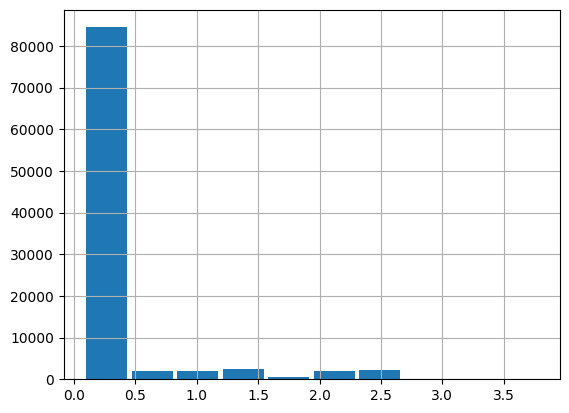

In [1844]:
# bins of conso scale by hour
month['kWh'].hist(bins=10, density=False, histtype='bar',rwidth=0.9, align='mid')

<Axes: >

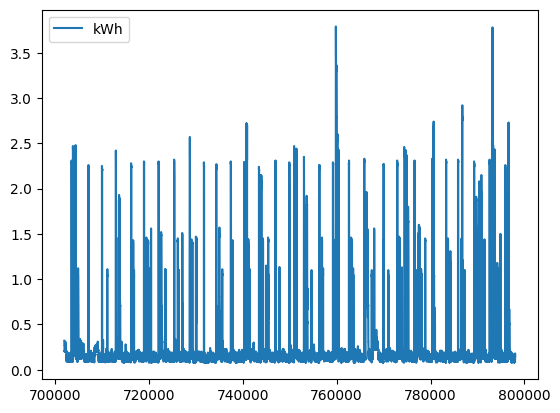

In [1845]:
month.plot()

In [1846]:
# index with max conso in this month
month.idxmax().kWh

np.int64(759841)

In [1847]:
# plot month day max conso (télévision de 11h à 23h)
day_idx = month.idxmax()
#day = '27/10/2024'
day_idx

day       795116
hours     705559
months    702031
kWh       759841
dtype: int64

In [1848]:
#show(day,pltcolor='darkcyan')
#conso_byhour(day)

In [1849]:
grp_by_dayhours

kWh  cumsum  diff  days
days     hours                         
30/08/24 04      50      50   NaN   NaN
         05     147     197  97.0   NaN
         06     129     326 -18.0   NaN
         07     121     447  -8.0   NaN
         08     148     595  27.0   NaN
...             ...     ...   ...   ...
08/07/25 16     101    2114   7.0  17.0
         17      99    2213  -2.0  18.0
         18     113    2326  14.0  19.0
         19     139    2465  26.0  20.0
         20     172    2637  33.0  21.0

[7505 rows x 4 columns]

In [1850]:
month

,day,hours,months,kWh
702031,01,00,2025-04,0.32
702032,01,00,2025-04,0.28
702033,01,00,2025-04,0.28
702034,01,00,2025-04,0.28
702035,01,00,2025-04,0.28
...,...,...,...,...
798012,30,23,2025-04,0.15
798013,30,23,2025-04,0.15
798014,30,23,2025-04,0.15
798015,30,23,2025-04,0.15


In [1851]:
month.idxmax()


day       795116
hours     705559
months    702031
kWh       759841
dtype: int64

In [1852]:
month.loc[month.idxmax().kWh]


day            19
hours          14
months    2025-04
kWh          3.79
Name: 759841, dtype: object

In [1853]:
grp_by_dayhours.loc[['28/02/25']].kWh

days      hours
28/02/25  00       174
          01       179
          02       162
          03       120
          04       102
          05       110
          06       111
          07       108
          08       101
          09       110
          10       110
          11       105
          12       170
          13       145
          14       148
          15       143
          16       191
          17       145
          18       199
          19       154
          20       152
          21       144
          22       151
          23       173
Name: kWh, dtype: int64

In [1854]:
max_hour = grp_by_dayhours.loc[['28/02/25']].kWh.idxmax()[1]
max_hour

'18'

<Axes: xlabel='days,hours'>

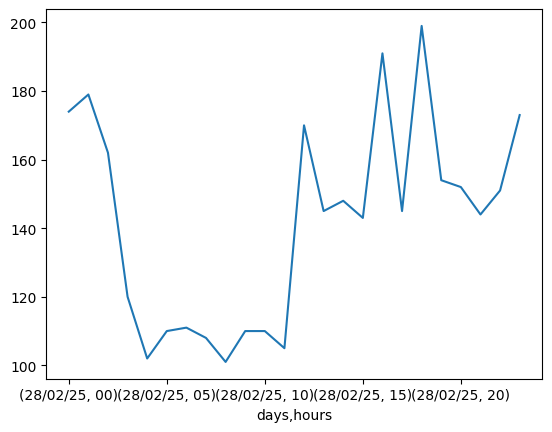

In [1855]:
grp_by_dayhours.loc[['28/02/25']].kWh.plot()#.idxmax()

In [1856]:
grp_by_dayhours.columns

Index(['kWh', 'cumsum', 'diff', 'days'], dtype='object')

In [1857]:
# diff
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['diff'],label=grp_by_dayhours.columns[2])
# plt.legend()

In [1858]:
# cumsum
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['cumsum'],label=grp_by_dayhours.columns[1])
# plt.legend()

In [1859]:
# 41 s
# file to big to git sync

# create .gitignore
filename=r'../conso_data.csv'
#conso_data.to_csv(filename)
#43.6s size 140128 kB